# Voodoo Homework

### Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date

### Load the raw data

In [56]:
DATA_TRAIN_PATH = "../data/raw/train_samples.parquet"
df_train = pd.read_parquet(
    path=DATA_TRAIN_PATH
)
DATA_TEST_PATH = "../data/raw/test_samples.parquet"
df_test = df = pd.read_parquet(
    path=DATA_TEST_PATH
)

df = pd.concat([df_train, df_test], axis=0)

## Exploration

In [77]:
df_train.head()

,user_id,platform,is_optin,install_date,game_type,app_id,country,ad_network_id,campaign_type,campaign_id,...,booster_used_count_d90,booster_used_count_d120,rv_shown_count_d0,rv_shown_count_d3,rv_shown_count_d7,rv_shown_count_d14,rv_shown_count_d30,rv_shown_count_d60,rv_shown_count_d90,rv_shown_count_d120
0,667998,android,1,2023-02-09,casual,1066,GB,25,B,3a6a96ad8037e584ab9c4506cde09949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1398972,ios,0,2023-02-09,casual,1067,US,33,B,,...,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,706857,ios,0,2023-02-09,casual,1067,US,25,A,da20b8ac340cace30b34643d87584a55,...,18.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,394955,ios,0,2023-02-09,casual,1067,US,33,B,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,494476,ios,0,2023-02-09,casual,1067,US,25,A,da20b8ac340cace30b34643d87584a55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
# The current problem is to predict d120 revenue based only on first day data.
# Every columns containing data in between are useless
# We will remove them
COLS_TO_KEEP = [
    c
    for c in df.columns
    if "d3" not in c
    if "d7" not in c    
    if "d14" not in c    
    if "d30" not in c
    if "d60" not in c    
    if "d90" not in c
]

In [79]:
dict(df[COLS_TO_KEEP].loc[0])

{'user_id': 667998,
 'platform': 'android',
 'is_optin': 1,
 'install_date': Timestamp('2023-02-09 00:00:00'),
 'game_type': 'casual',
 'app_id': 1066,
 'country': 'GB',
 'ad_network_id': 25,
 'campaign_type': 'B',
 'campaign_id': '3a6a96ad8037e584ab9c4506cde09949',
 'model': 'SM-S901B',
 'manufacturer': 'samsung',
 'mobile_classification': 'TIER 2',
 'city': 'Liverpool',
 'd0_ad_rev': 0.0050375978,
 'd120_ad_rev': 0.0050375978,
 'd0_iap_rev': 0.0,
 'd120_iap_rev': 0.0,
 'd0_rev': 0.0050375978,
 'd120_rev': 0.0050375978,
 'iap_count_d0': 0.0,
 'iap_count_d120': 0.0,
 'iap_coins_rev_d0': 0.0,
 'iap_coins_rev_d120': 0.0,
 'iap_coins_count_d0': 0.0,
 'iap_coins_count_d120': 0.0,
 'iap_ads_rev_d0': 0.0,
 'iap_ads_rev_d120': 0.0,
 'iap_ads_count_d0': 0.0,
 'iap_ads_count_d120': 0.0,
 'ad_count_d0': 11.0,
 'ad_count_d120': 11.0,
 'game_count_d0': 10.0,
 'game_count_d120': 10.0,
 'session_count_d0': 1.0,
 'session_count_d120': 1.0,
 'current_level_d0': 8.0,
 'current_level_d120': 8.0,
 'sessi

Create a cohort column based on the columns
- install_date
- country
- ad_network_id
- campaign_id

In [80]:
df["cohort"] = df.apply(
    lambda x: hash((
        x["install_date"],
        x["country"],
        x["ad_network_id"],
        x["campaign_id"]
    )),
    axis = 1
)

Apply log to all revenue columns

In [81]:
%%capture
### Remove warnings due to 0 or NaN values
for c in df.columns:
    if "rev" in c:
        df[f"{c}_log"] = np.log(df[c])

In [96]:
IDS = [
    "user_id",
    "cohort",
]

USER_FEATURES = [
    "app_id",
    "install_date",
    "platform",
    "is_optin",
    "game_type",
    "country",
    "country",
    "manufacturer",
    "mobile_classification",
    "city",
]

ENGAGEMENT_FEATURES = [
    "iap_count_d0",
    "iap_coins_rev_d0_log",
    "iap_coins_count_d0",
    "iap_ads_rev_d0_log",
    "iap_ads_count_d0",
    "ad_count_d0",
    "session_count_d0",
    "game_count_d0",
    "current_level_d0",
    "session_length_d0",
    "coins_spend_sum_d0",
    "booster_used_count_d0",
    "rv_shown_count_d0",
]

TARGET_AD = ["d120_ad_rev_log"]
TARGET_IAP = ["d120_iap_rev_log"]
TARGET_TOTAL = ["d120_rev_log"]

TARGETS = TARGET_AD + TARGET_IAP + TARGET_TOTAL

### Target 

In [83]:
# Proportion of empty d120_rev
sum(df["d120_rev_log"].isna()) / len(df)

0.5410672497360768

#### Distribution

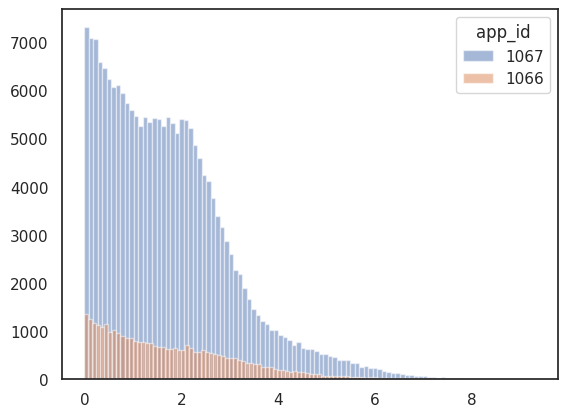

In [84]:
import matplotlib.pyplot as plt

data = []
for app_id in df["app_id"].unique():
    data += [
        (
            app_id,
            df[(df["d120_rev_log"] > 0) & (df["app_id"] == app_id)]["d120_rev_log"]
        )
    ]

#add four histograms to one plot
for d in data[::-1]:  # Change the order to better visualization
    plt.hist(d[1], bins=100, alpha=0.5, label=d[0])
plt.legend(title='app_id')
plt.show()

#### Average value over time

<AxesSubplot: xlabel='install_date'>

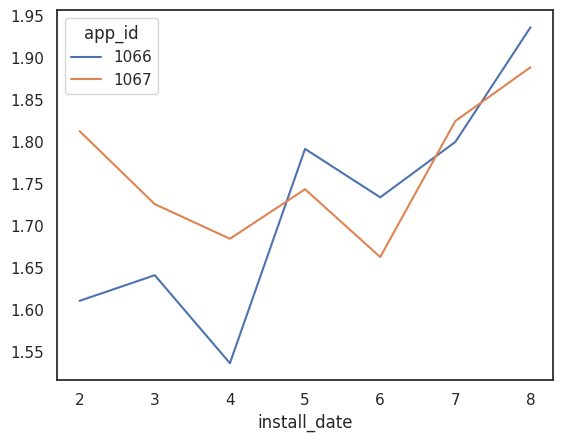

In [85]:
df[(df["d120_rev_log"] > 0)].groupby([df["app_id"], df["install_date"].dt.month])["d120_rev_log"].mean().unstack().unstack().unstack().plot()

#### Monthly new uers

<AxesSubplot: xlabel='install_date'>

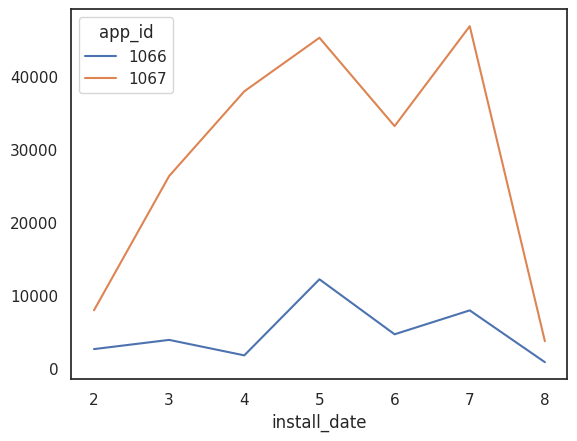

In [105]:
df[(df["d120_rev_log"] > 0)].groupby([df["app_id"], df["install_date"].dt.month])["user_id"].count().unstack().unstack().unstack().plot()

#### Correlation

<AxesSubplot: >

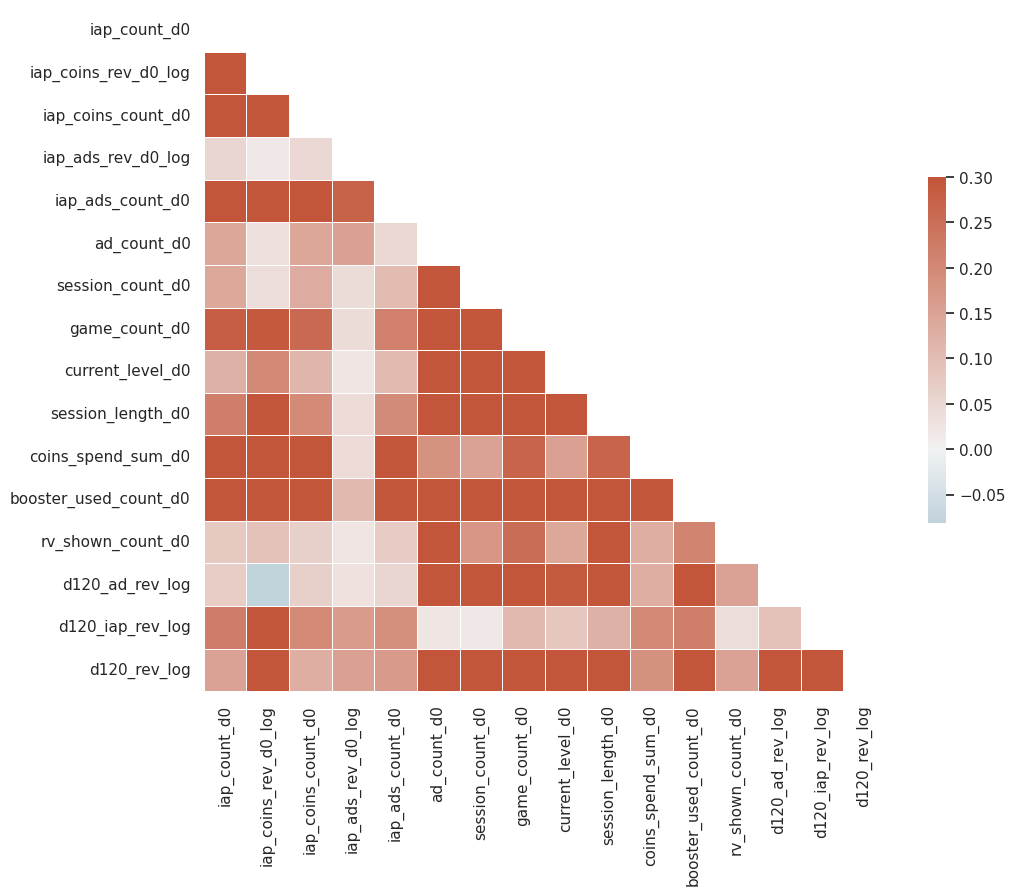

In [86]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df[ENGAGEMENT_FEATURES + TARGETS].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [87]:
# users does not have multiple apps
df.user_id.value_counts()

667998     1
767489     1
1381622    1
784321     1
1141189    1
          ..
1036704    1
295029     1
1003477    1
867163     1
1542842    1
Name: user_id, Length: 1770401, dtype: int64

### Compute new features

In [88]:
# Birch algorithm on Engagement feature

In [89]:
# Decision Tree on User Features

In [90]:
# Compute min max avg per cluster

In [91]:
# Prediction of the best power value (1/x)

### Train Eval Test split

In [92]:
df[(df["d120_rev_log"] > 0)].install_date.max()

Timestamp('2023-08-03 00:00:00')

In [93]:
df_test.head().install_date.max()

Timestamp('2023-12-01 00:00:00')

In [94]:
# We don't use the first and last days as they seem incomplete or worse, buggy
TRAIN_START_DATE = "2023-02-09"
TRAIN_END_DATE = "2023-06-30"

EVAL_START_DATE = "2023-07-01"
EVAL_END_DATE = "2023-08-03"

TEST_START_DATE = "2023-12-01"
TEST_END_DATE = "2023-12-01"

In [102]:
X_train = df[
    (df["install_date"] >= TRAIN_START_DATE) &
    (df["install_date"] <= TRAIN_END_DATE) &
    (~df["d120_rev_log"].isna())
][USER_FEATURES + ENGAGEMENT_FEATURES + ["d120_rev_log"]]

y_train = X_train.pop("d120_rev_log")

X_eval = df[
    (df["install_date"] >= EVAL_START_DATE) &
    (df["install_date"] <= EVAL_END_DATE) &
    (~df["d120_rev_log"].isna())
][USER_FEATURES + ENGAGEMENT_FEATURES + ["d120_rev_log"]]

y_eval = X_eval.pop("d120_rev_log")

X_test = df[
    (df["install_date"] >= TEST_START_DATE) &
    (df["install_date"] <= TEST_END_DATE)
][USER_FEATURES + ENGAGEMENT_FEATURES + ["d120_rev_log"]]

### Simple predictions

In [106]:
X_train

,app_id,install_date,platform,is_optin,game_type,country,country,manufacturer,mobile_classification,city,...,iap_ads_rev_d0_log,iap_ads_count_d0,ad_count_d0,session_count_d0,game_count_d0,current_level_d0,session_length_d0,coins_spend_sum_d0,booster_used_count_d0,rv_shown_count_d0
0,1066,2023-02-09,android,1,casual,GB,GB,samsung,TIER 2,Liverpool,...,-inf,0.0,11.0,1.0,10.0,8.0,244.0,0.0,0.0,0.0
1,1067,2023-02-09,ios,0,casual,US,US,Apple,TIER 3,,...,-inf,0.0,30.0,2.0,16.0,14.0,1350.0,0.0,0.0,0.0
2,1067,2023-02-09,ios,0,casual,US,US,Apple,IOS NA,Tucson,...,-inf,0.0,439.0,9.0,33.0,25.0,1756.0,0.0,0.0,0.0
3,1067,2023-02-09,ios,0,casual,US,US,Apple,IOS NA,Owings Mills,...,-inf,0.0,20.0,2.0,5.0,3.0,116.0,0.0,0.0,0.0
4,1067,2023-02-09,ios,0,casual,US,US,Apple,TIER 3,Rochester,...,-inf,0.0,272.0,3.0,71.0,54.0,1719.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621367,1067,2023-06-30,ios,0,casual,US,US,Apple,IOS NA,Goshen,...,-inf,0.0,13.0,1.0,5.0,4.0,246.0,0.0,0.0,0.0
621368,1067,2023-06-30,ios,0,casual,GB,GB,Apple,IOS NA,Edinburgh,...,-inf,0.0,60.0,2.0,15.0,11.0,679.0,100.0,1.0,0.0
621369,1067,2023-06-30,ios,0,casual,US,US,Apple,TIER 2,Bay City,...,-inf,0.0,18.0,1.0,8.0,6.0,401.0,100.0,1.0,0.0
621370,1067,2023-06-30,ios,0,casual,US,US,Apple,TIER 2,Washington,...,-inf,0.0,3.0,1.0,3.0,2.0,68.0,0.0,0.0,0.0


In [108]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

In [ ]:
numeric_preprocessor = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("categorical", categorical_preprocessor, ["day"]),
    ("numerical", numeric_preprocessor, ["total_bill", "size"])
])

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LinearRegression())
])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
# Output: 0.5706168878130049

X_test_new = pd.DataFrame( {'total_bill': [25, 45], 'day': ['Sun', 'Mon'], 'size': [2, 4]} )
pipe.predict(X_test_new)
# Output: array([3.27325822, 5.436413  ])